# 필요한 파일 불러오기 및 데이터 확인

In [11]:
import numpy as np
import os
os.chdir("./")

import pandas as pd
from pandas import DataFrame

import warnings
warnings.filterwarnings(action='ignore')

In [12]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
submssion=pd.read_csv("submission_제출양식.csv")

FileNotFoundError: [Errno 2] File b'train.csv' does not exist: b'train.csv'

In [6]:
train.head(3)

NameError: name 'train' is not defined

train 데이터를 육안으로 확인해본 결과, date, 현재 정류장의 위도, 경도와 다음 정류장의 위도, 경도

그리고 현재 정류장 도착시간, 이동한 거리 정도가 당장 사용이 가능한 변수들로 보이며,

목적변수인 next_arrive_time이 확인이 되었다.

# 사용 변수 범주화

## date -> 요일 변환, 시간대 결합

date 컬럼을 판다스의 datetime 변수형으로 변환한다.

In [4]:
train['date'] = pd.to_datetime(train['date'])

date 컬럼으로부터 요일을 뽑아낸다.

In [5]:
train['weekday'] = train['date'].dt.weekday

파이썬 도큐멘테이션에는 weekday를 아래와 같이 설명하고 있다.

Return the day of the week as an integer, where Monday is 0 and Sunday is 6.

weekday 변수 생성 후 pandas의 get_dummies 함수를 활용하여 weekday에 대한 one hot encoding을 실행한다.

In [6]:
train = pd.get_dummies(train,columns=['weekday'])

test 데이터에 대해서도 위와 똑같은 변환을 해준다.

In [7]:
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

그 다음으로는 기존에 존재하는 now_arrive_time 변수의 경우,

시간대가 너무 다양하여서 바로 one hot encoding을 하기에는 무리라고 보았습니다.

따라서 이를 아침, 오후, 저녁으로 그룹화를 진행하여서 이를 one hot encoding을 실행하였습니다

In [8]:
train['time_group']='group' #time_group 변수를 미리 생성

train.loc[ (train['now_arrive_time']>='05시') & (train['now_arrive_time']<'12시') ,['time_group'] ]= 'morning' # 05~11시
train.loc[ (train['now_arrive_time']>='12시') & (train['now_arrive_time']<'18시') ,['time_group'] ]= 'afternoon' #12~17시
train.loc[ (train['now_arrive_time']>='18시') | (train['now_arrive_time']=='00시'),['time_group'] ]= 'evening' #18~00시

train = pd.get_dummies(train,columns=['time_group'])

test 데이터에 대해서도 위와 똑같은 변환을 해준다.

In [9]:
test['time_group']='group'

test.loc[ (test['now_arrive_time']>='05시') & (test['now_arrive_time']<'12시') ,['time_group'] ]= 'morning'
test.loc[ (test['now_arrive_time']>='12시') & (test['now_arrive_time']<'18시') ,['time_group'] ]= 'afternoon'
test.loc[ (test['now_arrive_time']>='18시') | (test['now_arrive_time']=='00시'),['time_group'] ]= 'evening'

test = pd.get_dummies(test,columns=['time_group'])

# 현재 정류장 위도, 경도 활용하기

제주도에서 주로 활성화가 된 지역은 제주국제공항 근처, 서귀포 지역이다.

그렇다면, 이러한 주로 활성화 된 지역에서의 특징이 도착시간을 예측하는지 도움이 되는지 확인을 하고자 하였다.

위도, 경도를 활용하여서 지도에 표시를 해주는 folium 패키지를 불러오고

이 중에서도 마커를 만들고 이를 확대,축소가 되는 것에 따라 마커들을 모아주는 MarkerCluster를 활용한다


In [1]:
!pip install folium
import folium
from folium.plugins import MarkerCluster

#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['now_latitude','now_longitude','now_station']].drop_duplicates(keep='first')

KeyboardInterrupt: 

In [11]:
#제주도 지역의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=10.5)

In [12]:
#각각의 점에 마커를 만들고, 이 포인트들을 확인할 수 있도록 map_osm에 넣는다.
mc = MarkerCluster()
for row in data.itertuples():
    mc.add_child(folium.Marker(location=[row.now_latitude,  row.now_longitude], popup=row.now_station)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
map_osm

map_osm을 통해서 확인해본 결과, 제주국제공항 근처, 서귀포시

그리고 성산일출봉 근처, 한라산 근처로만 버스 정류장이 주어진 것을 확인할 수 있었다.

이 네 구역을 중심으로 해당 버스정류장에서 가장 가까운 지역이 어디인지를 찾는 알고리즘을 만들고

가장 가까운 지역으로만 그룹화를 해보는 작업을 시행해 보았다.

In [13]:
# 해당 주요 장소의 임의 지역 위도, 경도
up=(33.506286, 126.490312) # 제주국제공항 근처
right=(33.493521, 126.895326) #성산일출봉 근처
down=(33.246742, 126.562387) #서귀포시 근처
center=(33.379724, 126.545315) #성산일출봉 근처

In [15]:
!pip install geopy
import geopy.distance #거리 계산해주는 패키지 사용

list comprehesion을 활용하여서, 각각 정류장의 위도, 경도를 불러오고 이를 투입해 주요장소와의 km를 구할 수 있게 함

geopy.distance.vincenty는 위도, 경도가 주어졌을 때,

두 구간의 직선 거리를 구하는 함수로 km, m등을 추가하여서 해당 단위에 맞는 값을 구할 수 있게 해줌

In [16]:
t1 = [geopy.distance.vincenty( (i,j), up).km for i,j in list( zip( train['now_latitude'],train['now_longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), down).km for i,j in list( zip( train['now_latitude'],train['now_longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), right).km for i,j in list( zip( train['now_latitude'],train['now_longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), center).km for i,j in list( zip( train['now_latitude'],train['now_longitude'] )) ]

해당 거리의 리스트들을 DataFrame으로 만들고, 각 행의 거리들 중에서 가장 값이 작은 것에 대한 열의 이름을 가지고 와서,

train의 dist_name이라는 변수에 넣고 one hot encoding을 실행한다.

In [18]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['up','down','right','center'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
train = pd.get_dummies(train,columns=['dist_name'])

test data도 동일한 과정을 실행해준다

In [19]:
t1 = [geopy.distance.vincenty( (i,j), up).km for i,j in list( zip( test['now_latitude'],test['now_longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), down).km for i,j in list( zip( test['now_latitude'],test['now_longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), right).km for i,j in list( zip( test['now_latitude'],test['now_longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), center).km for i,j in list( zip( test['now_latitude'],test['now_longitude'] )) ]

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['up','down','right','center'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
test = pd.get_dummies(test,columns=['dist_name'])

그리고 현재 train data에는 버스가 실제로 이동한 거리가 주어져있다.

그렇다면 현재 정류장의 위도,경도와 다음 정류장의 위도, 경도를 활용하여 직선거리를 구해서 변수로 넣어본다면

어떠한 결과가 나올지 보려고 한다.

위에서와 동일하게 list comprehesion을 활용하여서, 각각 정류장의 위도, 경도를 불러오고 이를 투입해

해당 정류장간의 직선 거리를 구하였다

In [20]:
train['distance_line']=[ geopy.distance.vincenty( (i,j), (k,l) ).km 
 for i,j,k,l in list( zip( train['now_latitude'],train['now_longitude'],train['next_latitude'],train['next_longitude'] ) ) ]


test data도 동일한 과정을 실행해준다

In [21]:
test['distance_line']=[ geopy.distance.vincenty( (i,j), (k,l) ).km 
 for i,j,k,l in list( zip( test['now_latitude'],test['now_longitude'],test['next_latitude'],test['next_longitude'] ) ) ]

# 모형 구축 및 예측값 구하기

이렇게 요일, 시간대, 위도 경도를 활용한 지역 그룹화 변수를 만들었다면, 기존보다 많은 변수명이 보일 것이다.

실제로 사용할 변수들은 id, route_id가 아닌 distance와 one hot encoding을 한 변수들이기 때문에

이를 모형 구축을 할 때 일일히 입력하는 것이 아닌 빠르게 입력하기 위해, input_var, target을 만들도록 하였다.

목적변수인 next_arrive_time 이후의 columns의 이름들과 distance를 합쳐서 하나의 리스트로 만들었다


In [22]:
input_var= list( train.columns[14:] ) + ['distance']
target=['next_arrive_time']

input_var

['weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'time_group_afternoon',
 'time_group_evening',
 'time_group_morning',
 'dist_name_center',
 'dist_name_down',
 'dist_name_right',
 'dist_name_up',
 'distance_line',
 'distance']

해당 만든 변수명들을 train, test에 넣어 X_train, y_train, X_test라는 DataFrame을 새로 만든다

In [23]:
X_train=train[input_var]
y_train=train[target]

X_test=test[input_var]

현재 활용하고자 하는 알고리즘은 기존 분류모델인 RandomForest에서의 회귀모형 버전인 RandomForestRegressor이다.

In [24]:
from sklearn.ensemble import RandomForestRegressor

#코드를 실행하는 다른 사람들에게도 동일한 결과를 보이게 하기 위해, random_state라는 seed number를 임의의 번호로 할당
rf = RandomForestRegressor(random_state=1217)  #RandomForestRegressor 생성

In [25]:
rf.fit(X_train,y_train) #생성된 트리모델을 학습시키는 과정


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1217, verbose=0, warm_start=False)

RandomForest는 변수 중요도라는 요소를 활용하여, 어떠한 변수가 예측값을 만드는데 더 중요하게 사용이 됬는지 확인할 수 있다.

이러한 변수 중요도를 시각적으로 표현하여서, 어떠한 변수가 중요하였고, 어떠한 변수가 개선이 필요한지 확인하고자 한다.

In [26]:
import matplotlib.pyplot as plt

n_feature = X_train.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)

학습된 rf에서 feature_importance_를 입력하면, 해당 변수에 대한 변수 중요도가 수치적으로 나타난다.

이를 수평 막대 그래프를 활용하여 그리는 과정은 다음과 같다.

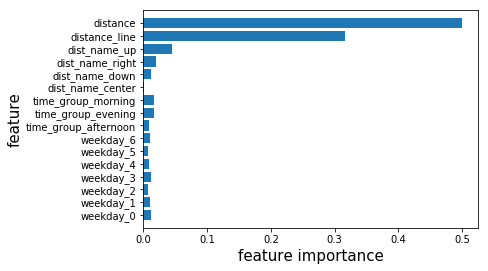

In [27]:
plt.barh(index, rf.feature_importances_, align='center') #
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

확인해본 결과, distance, 직선거리인 distance_line이 모형 구축하는데 중요하게 사용이 된 변수들로 확인이 되었다.

현재 one hot encoding을 한 변수들의 경우, 덜 중요하게 사용이 되었기 때문에, 이러한 사항들을 고려하여서 추가적인 모형 구축이 필요하여 보인다.

일단 RandomForestRegressor 모델이 학습이 되었기 때문에, 이를 X_test DataFrame을 넣어 예측값을 만들려고 한다,

이를 활용하기 위해서는 기존 학습된 rf에 predict를 추가한 뒤, test data로 할당된 DataFrame을 넣는다.


In [28]:
test['next_arrive_time'] = rf.predict(X_test)

해당 submissoin_제출양식.csv.는 id와 next_arrive_time 변수로만 이루어져있기 때문에,

해당 두 변수들만 test에서 가져온 뒤, 이를 csv파일로 변환하여서 내보내었다.

이 때, 반드시 index=False를 설정해주어야지 index 열 추가 문제로 인한 제출오류가 발생하지 않는다.


In [29]:
test[['id','next_arrive_time']].to_csv("dacon_base_line.csv",index=False)